#### Main libraries

In [1]:
import pandas as pd
import numpy as np
#import tiingo
import requests


In [2]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
cal = calendar()

holidays = cal.holidays(start='2000-01-01',
                        end='2030-12-30')

holiday_df = pd.DataFrame(data=holidays,
                          columns = ['date']).assign(holiday='USFederalHoliday')

In [3]:
holiday_df

,date,holiday
0,2000-01-17,USFederalHoliday
1,2000-02-21,USFederalHoliday
2,2000-05-29,USFederalHoliday
3,2000-07-04,USFederalHoliday
4,2000-09-04,USFederalHoliday
...,...,...
304,2030-09-02,USFederalHoliday
305,2030-10-14,USFederalHoliday
306,2030-11-11,USFederalHoliday
307,2030-11-28,USFederalHoliday


In [4]:
### First we will get the 15min time intervals and calculate the 15min Moving averages (10 perido, 20 period, 50 period)
### From the same data we will also calculate the 1d Moving averages (10 period, 20 period, 50 period) and
### Append the indicators to the dataframe 
### Each iteration will run for a single ticker


### The data extracts work in 0GMT => Exchange opens at 14:30 and closes at 21:00
### Convert this to Sofia/New-York time if needed


### Load content

In [5]:
# 15min to # 1h 
headers = {
    'Content-Type': 'application/json'
}
requestResponse = requests.get("https://api.tiingo.com/iex/tmus/prices?startDate=2017-01-02&resampleFreq=1hour&columns=open,high,low,close,volume&token=0ed744c7db5ef348139953912e2f3cee79f4608b", headers=headers)
#print(requestResponse.json())

In [6]:
## This gets financial data
#requestResponse = requests.get("https://api.tiingo.com/tiingo/fundamentals/msft/statements?token=0ed744c7db5ef348139953912e2f3cee79f4608b", headers=headers)
#print(requestResponse.json)

In [7]:
requestResponse

<Response [200]>

In [8]:
df_stock = pd.DataFrame(requestResponse.json()) 

In [9]:
df_stock

,date,open,high,low,close,volume
0,2017-06-12T15:00:00.000Z,64.340,64.420,64.125,64.22,11889.0
1,2017-06-12T16:00:00.000Z,64.220,64.420,64.060,64.42,10035.0
2,2017-06-12T17:00:00.000Z,64.300,64.750,64.300,64.74,21780.0
3,2017-06-12T18:00:00.000Z,64.740,64.750,64.580,64.67,8656.0
4,2017-06-12T19:00:00.000Z,64.670,64.715,64.540,64.68,8489.0
...,...,...,...,...,...,...
9995,2022-12-01T15:00:00.000Z,153.040,153.360,150.980,152.24,29693.0
9996,2022-12-01T16:00:00.000Z,152.290,152.470,151.910,152.05,15601.0
9997,2022-12-01T17:00:00.000Z,152.005,152.010,151.420,151.66,5848.0
9998,2022-12-01T18:00:00.000Z,151.720,151.970,151.290,151.69,8529.0


In [10]:
df_stock.date = pd.to_datetime(df_stock.date)

In [11]:
df_stock.date.dt.date

0       2017-06-12
1       2017-06-12
2       2017-06-12
3       2017-06-12
4       2017-06-12
           ...    
9995    2022-12-01
9996    2022-12-01
9997    2022-12-01
9998    2022-12-01
9999    2022-12-01
Name: date, Length: 10000, dtype: object

In [12]:
## Remove the US public holidays
df_stock = df_stock[~df_stock.date.dt.date.isin(holiday_df.date)]

c:\Users\IvanIvanov\Anaconda3\lib\site-packages\pandas\core\algorithms.py:524: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  return f(comps, values)


In [13]:
df_stock.dtypes

date      datetime64[ns, UTC]
open                  float64
high                  float64
low                   float64
close                 float64
volume                float64
dtype: object

#### Prophet

In [14]:
from prophet import Prophet

In [15]:
df_stock.rename(columns={"date": "ds", "close": "y"},inplace=True)

c:\Users\IvanIvanov\Anaconda3\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [16]:
df_stock

,ds,open,high,low,y,volume
0,2017-06-12 15:00:00+00:00,64.340,64.420,64.125,64.22,11889.0
1,2017-06-12 16:00:00+00:00,64.220,64.420,64.060,64.42,10035.0
2,2017-06-12 17:00:00+00:00,64.300,64.750,64.300,64.74,21780.0
3,2017-06-12 18:00:00+00:00,64.740,64.750,64.580,64.67,8656.0
4,2017-06-12 19:00:00+00:00,64.670,64.715,64.540,64.68,8489.0
...,...,...,...,...,...,...
9995,2022-12-01 15:00:00+00:00,153.040,153.360,150.980,152.24,29693.0
9996,2022-12-01 16:00:00+00:00,152.290,152.470,151.910,152.05,15601.0
9997,2022-12-01 17:00:00+00:00,152.005,152.010,151.420,151.66,5848.0
9998,2022-12-01 18:00:00+00:00,151.720,151.970,151.290,151.69,8529.0


In [17]:
df_stock.ds = df_stock.ds.dt.tz_convert(None)

c:\Users\IvanIvanov\Anaconda3\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [18]:
# Python
m = Prophet()
m.fit(df_stock[['ds','y']])

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [19]:
# Python
future = m.make_future_dataframe(periods=4)
future.tail()

,ds
9992,2022-12-01 19:00:00
9993,2022-12-02 19:00:00
9994,2022-12-03 19:00:00
9995,2022-12-04 19:00:00
9996,2022-12-05 19:00:00


In [20]:
# Python
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
9992,2022-12-01 19:00:00,143.871414,139.694868,148.030939
9993,2022-12-02 19:00:00,143.715898,139.372922,147.908385
9994,2022-12-03 19:00:00,144.299831,139.786688,148.251744
9995,2022-12-04 19:00:00,143.894264,139.714465,147.966340
9996,2022-12-05 19:00:00,143.154604,139.098927,147.342460


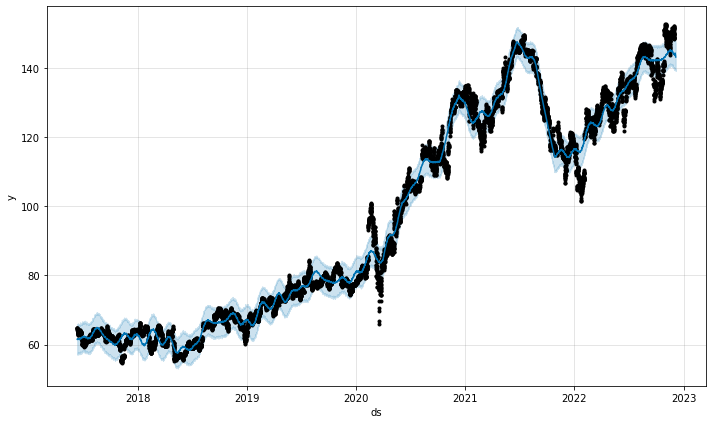

In [21]:
# Python
fig1 = m.plot(forecast)

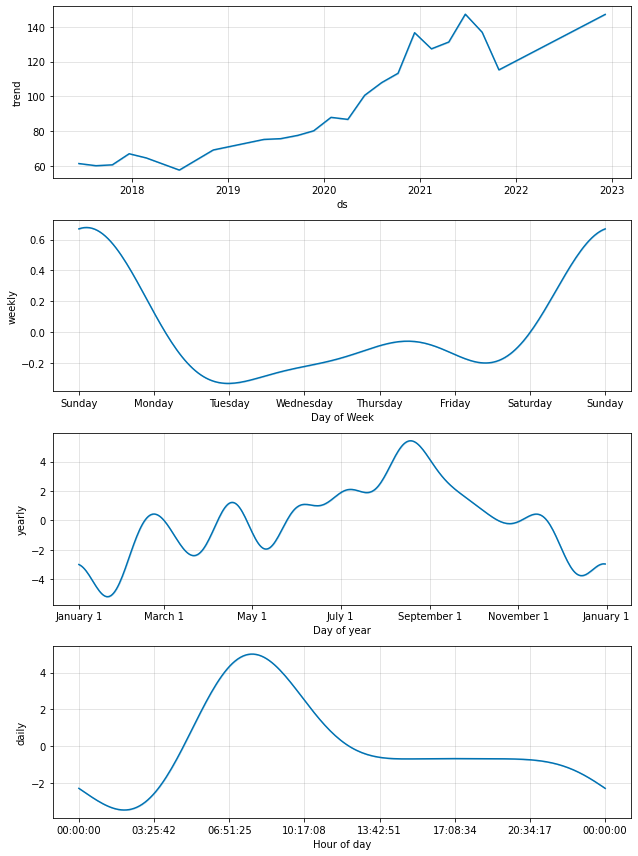

In [22]:
# Python
fig2 = m.plot_components(forecast)

In [23]:
# Python
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

In [24]:
# Python
plot_components_plotly(m, forecast)

In [ ]:
df_stock[['ds','y']]

In [ ]:
#df_stock["statementData"][3]

In [ ]:
### Create a database of unwanted dates i.e. when the exchange was halted due to
### public holidays, etc. for data pre-processing

dates_to_exclude = pd.to_datetime(['2021-02-15',
                    '2021-04-02',
                    '2021-05-31',
                    '2021-07-05',
                    '2021-09-06',
                    '2021-11-25',
                    '2021-12-24',
                    '2022-01-17',
                    '2022-02-21',
                    '2022-04-15',
                    '2022-05-30',
                    '2022-06-20',
                    '2022-07-04'])
# Create an empty list
unwanted_dates = []

for x in dates_to_exclude:
    print("Day excluded due to public holdiay:",x.date())
    unwanted_dates.append(x.date())

In [ ]:
def df_stock_preprocessing(df_input):
    # Convert the date to pandas datetime very important
    df_input.date = pd.to_datetime(df_input.date)
    # Clear public holidays
    df_input = df_input[~df_input.date.dt.date.isin(unwanted_dates)]
    return df_input


def calculate_datetimes(df_input):
    df_input = df_input.sort_values(['date'])
    
    df_input['year'] = df_input.date.dt.year
    df_input['month'] = df_input.date.dt.month
    df_input['day'] = df_input.date.dt.day
    df_input['hour'] = df_input.date.dt.hour
    df_input['mins'] = df_input.date.dt.minute
    
    return df_input



In [ ]:
# Execute the function to get clean date without the public holidays
df_stock = df_stock_preprocessing(df_stock)
# Execute the function to get columns for year, month, day, hour and mins
df_stock = calculate_datetimes(df_stock)


In [ ]:
df_stock

In [ ]:
# Check for the days with zero volume in order to remove them from the database i.e. public holidays, etc.
#x = df_stock[df_stock['volume']==0].groupby(['year','month','day']).volume.value_counts()
#x.to_csv('zero_days.csv')

In [ ]:
combined_df = df_stock

In [ ]:
combined_df

In [ ]:
hourly_df = combined_df.groupby(['year','month','day','hour']).last().reset_index()
hourly_df.close = hourly_df.close.shift(1)
hourly_df['hour_ma10'] = hourly_df.close.rolling(window=10).mean()
hourly_df['hour_ma20'] = hourly_df.close.rolling(window=20).mean()
hourly_df['hour_ma50'] = hourly_df.close.rolling(window=50).mean()

In [ ]:
hourly_df

In [ ]:
df_stock.close.shift(1).rolling(window=10).mean()

In [ ]:
#### PERFORMANCE 
def df_ind_fast_calc(df_input):
    combined_df = df_input
    combined_df['ema_21'] = combined_df.close.ewm(span=21,adjust=False,min_periods=21).mean()
    # MA
    combined_df['ma10'] = combined_df.close.rolling(window=10).mean()
    combined_df['ma20'] = combined_df.close.rolling(window=20).mean()
    combined_df['ma50'] = combined_df.close.rolling(window=50).mean()
    
    
    # What happens next periods?
    combined_df['close1p_lead'] = combined_df.close.shift(-1)
    combined_df['close2p_lead'] = combined_df.close.shift(-2)
    combined_df['close3p_lead'] = combined_df.close.shift(-3)
    combined_df['close4p_lead'] = combined_df.close.shift(-4)
    combined_df['close5p_lead'] = combined_df.close.shift(-5)
    combined_df['close6p_lead'] = combined_df.close.shift(-6)
    combined_df['close7p_lead'] = combined_df.close.shift(-7)
    combined_df['close8p_lead'] = combined_df.close.shift(-8)
    combined_df['close16p_lead'] = combined_df.close.shift(-16)


    # Calculate the daily open for TODAY the stock and then join with the other dataframe based on year, month and day
    daily_open_df = combined_df.groupby(['year','month','day']).first().reset_index()
    daily_open_df = daily_open_df[['year','month','day','open']]
    daily_open_df = daily_open_df.set_axis(['year','month','day','daily_open'], axis=1, inplace=False)  
    combined_df= pd.merge(combined_df,daily_open_df,on=['year','month','day'],how='left')
    
    ### Pending question - can the low for today and high be calculated - because its moving for each row??? calc pwr?? 
    
    # Calculate the OPEN from YESTERDAY for the stock and then join with the other dataframe based on year,month and day
    yesterday_open_df = combined_df.groupby(['year','month','day']).first().shift(1).reset_index()
    yesterday_open_df = yesterday_open_df[['year','month','day','open']]
    yesterday_open_df = yesterday_open_df.set_axis(['year','month','day','yesterday_open'], axis=1, inplace=False)  
    combined_df= pd.merge(combined_df,yesterday_open_df,on=['year','month','day'],how='left')
    # Calculate the CLOSE from YESTERDAY for the stock and then join with the other dataframe based on year,month and day
    yesterday_close_df = combined_df.groupby(['year','month','day']).last().shift(1).reset_index()
    yesterday_close_df = yesterday_close_df[['year','month','day','close']]
    yesterday_close_df = yesterday_close_df.set_axis(['year','month','day','yesterday_close'], axis=1, inplace=False)  
    combined_df= pd.merge(combined_df,yesterday_close_df,on=['year','month','day'],how='left')
    # Yesterday LOW
    daily_low_df = combined_df.groupby(['year','month','day']).low.min().shift(1).reset_index()
    daily_low_df = daily_low_df.set_axis(['year','month','day','yesterday_low'], axis=1, inplace=False)
    combined_df = pd.merge(combined_df,daily_low_df,on=['year','month','day'],how='left')
    # Yesterday HIGH
    daily_high_df = combined_df.groupby(['year','month','day']).high.max().shift(1).reset_index()
    daily_high_df = daily_high_df.set_axis(['year','month','day','yesterday_high'], axis=1, inplace=False)
    combined_df = pd.merge(combined_df,daily_high_df,on=['year','month','day'],how='left')
    
    
    # Stock open for the day
    open_for_the_day_df = combined_df.groupby(['year','month','day']).first().reset_index()
    open_for_the_day_df = open_for_the_day_df[['year','month','day','open']]
    open_for_the_day_df = open_for_the_day_df.set_axis(['year','month','day','open_for_the_day'], axis=1, inplace=False)  
    combined_df= pd.merge(combined_df,open_for_the_day_df,on=['year','month','day'],how='left')
    # Stock close for the day
    close_for_the_day_df = combined_df.groupby(['year','month','day']).last().reset_index()
    close_for_the_day_df = close_for_the_day_df[['year','month','day','close']]
    close_for_the_day_df = close_for_the_day_df.set_axis(['year','month','day','close_for_the_day'], axis=1, inplace=False)  
    combined_df= pd.merge(combined_df,close_for_the_day_df,on=['year','month','day'],how='left')
    
    
    ## Hourly
    hourly_df = combined_df.groupby(['year','month','day','hour']).last().reset_index()
    hourly_df.close = hourly_df.close.shift(1)
    hourly_df['hour_ma10'] = hourly_df.close.rolling(window=10).mean()
    hourly_df['hour_ma20'] = hourly_df.close.rolling(window=20).mean()
    hourly_df['hour_ma50'] = hourly_df.close.rolling(window=50).mean()
    hourly_df = hourly_df[['year','month','day','hour','hour_ma10','hour_ma20','hour_ma50']]
    #hourly_ma = hourly_ma.set_axis(['year','month','day','hourly_ma'], axis=1, inplace=False)  
    combined_df= pd.merge(combined_df,hourly_df,on=['year','month','day','hour'],how='left')
    
       
    ## Daily
    daily_df = combined_df.groupby(['year','month','day']).last().reset_index()
    daily_df['close_day_minus1'] = daily_df.close.shift(1)
    daily_df['close_day_minus2'] = daily_df.close.shift(2)
    daily_df['close_day_minus3'] = daily_df.close.shift(3)
    daily_df['close_day_minus5'] = daily_df.close.shift(5)
    daily_df['close_day_minus10'] = daily_df.close.shift(10)
    daily_df['close_day_minus15'] = daily_df.close.shift(15)
    daily_df = daily_df[['year','month','day','close_day_minus1','close_day_minus2','close_day_minus3','close_day_minus5',
                        'close_day_minus10','close_day_minus15']]                                
    #hourly_ma = hourly_ma.set_axis(['year','month','day','hourly_ma'], axis=1, inplace=False)  
    combined_df= pd.merge(combined_df,daily_df,on=['year','month','day'],how='left')
    
   
    
    
      
    ## How things are calculated to percent depends on the variables - pay attention is it 100 - x/y*100 or x/y*100 -100!!!
    ## It depends which event occurs first it the timeline
    
    ### 
    combined_df["ema_21"] = combined_df.close/combined_df["ema_21"]*100 -100
    combined_df["ma10"] =  combined_df.close/combined_df["ma10"]*100-100
    combined_df["ma20"] =  combined_df.close/combined_df["ma20"]*100-100
    combined_df["ma50"] =  combined_df.close/combined_df["ma50"]*100-100
    combined_df["close1p_lead"] = 100 - combined_df.close/combined_df["close1p_lead"]*100
    combined_df["close2p_lead"] = 100 - combined_df.close/combined_df["close2p_lead"]*100
    combined_df["close3p_lead"] = 100 - combined_df.close/combined_df["close3p_lead"]*100
    combined_df["close4p_lead"] = 100 - combined_df.close/combined_df["close4p_lead"]*100
    combined_df["close5p_lead"] = 100 - combined_df.close/combined_df["close5p_lead"]*100
    combined_df["close6p_lead"] = 100 - combined_df.close/combined_df["close6p_lead"]*100
    combined_df["close7p_lead"] = 100 - combined_df.close/combined_df["close7p_lead"]*100
    combined_df["close8p_lead"] = 100 - combined_df.close/combined_df["close8p_lead"]*100
    combined_df["close16p_lead"] = 100 - combined_df.close/combined_df["close16p_lead"]*100
    
    
    combined_df["daily_open"] = combined_df.close/combined_df["daily_open"]*100 - 100
    combined_df["yesterday_open"] = combined_df.close/combined_df["yesterday_open"]*100 - 100
    combined_df["yesterday_close"] = combined_df.close/combined_df["yesterday_close"]*100 - 100
    combined_df["yesterday_low"] = combined_df.close/combined_df["yesterday_low"]*100 - 100
    combined_df["yesterday_high"] = combined_df.close/combined_df["yesterday_high"]*100 - 100
    combined_df["open_for_the_day"] = combined_df.close/combined_df["open_for_the_day"]*100 - 100
    combined_df["close_for_the_day"] = 100 - combined_df.close/combined_df["close_for_the_day"]*100
    
    combined_df["hour_ma10"] =  combined_df.close/combined_df["hour_ma10"]*100-100
    combined_df["hour_ma20"] =  combined_df.close/combined_df["hour_ma20"]*100-100
    combined_df["hour_ma50"] =  combined_df.close/combined_df["hour_ma50"]*100-100
    
    
    # How % is now close compared to close 1 day ago, 2 days ago etc. 
    combined_df['close_day_minus1'] = combined_df.close/combined_df['close_day_minus1']*100-100
    combined_df['close_day_minus2'] = combined_df.close/combined_df['close_day_minus2']*100-100
    combined_df['close_day_minus3'] = combined_df.close/combined_df['close_day_minus3']*100-100
    combined_df['close_day_minus5'] = combined_df.close/combined_df['close_day_minus5']*100-100
    combined_df['close_day_minus10'] = combined_df.close/combined_df['close_day_minus10']*100-100
    combined_df['close_day_minus15'] = combined_df.close/combined_df['close_day_minus15']*100-100


    #print(combined_df.columns)

    #print(daily_low_df)

    #print('swag')
    
    #print(yesterday_open_df)
    #print('swag')
    
    #print(yesterday_close_df)
    return combined_df


In [ ]:
df_stock

In [ ]:
x =df_ind_fast_calc(df_stock)

In [ ]:
x

In [ ]:
x.to_csv('bdin_now.csv')

In [ ]:
x.columns

In [ ]:
sector_etf = pd.read_excel ('C:/Users/IvanIvanov/Documents/BDIN/data/sector_list.xlsx', sheet_name='etf_list')
print (sector_etf)



In [ ]:
etf_list = list(sector_etf['Ticker'].values)

In [ ]:
etf_list

In [ ]:
# Load the companies and filter the big cap
big_cap = pd.read_excel("C:/Users/IvanIvanov/Documents/BDIN/data/big_cap.xlsx")
ticker_list = big_cap[big_cap['Market Cap']>4200000000]["Ticker"].to_list() # filter out only stocks with nice cap

In [ ]:
etf_list = list(sector_etf['Ticker'].values)

etf_list.extend(ticker_list)

#ticker_list = etf_list[0:300]

In [ ]:
len(ticker_list)

In [ ]:
import requests
from requests.exceptions import HTTPError
from requests.exceptions import InvalidURL
import time

In [ ]:
try:
    requestResponse = requests.get("https://api.tiingo.com/iex/"+ticker+"/prices?startDate=2019-01-02&resampleFreq=15min&columns=open,high,low,close,volume&token=0ed744c7db5ef348139953912e2f3cee79f4608b", headers=headers)
    requestResponse.raise_for_status()
except HTTPError:
    print ('Could not download page')
else:
    print (requestResponse.url, 'downloaded successfully')

In [ ]:
df_daily_all = pd.DataFrame()

for ticker in ticker_list[471:]:
    
    requestResponse = requests.get("https://api.tiingo.com/iex/"+ticker+"/prices?startDate=2019-01-02&resampleFreq=15min&columns=open,high,low,close,volume&token=0ed744c7db5ef348139953912e2f3cee79f4608b", headers=headers)
    df_stock = pd.DataFrame(requestResponse.json()) 
    print(df_stock.head())
    print(ticker)

    df_stock['ticker']=ticker
    df_daily_all = df_daily_all.append(df_stock)



In [ ]:
ticker_list.remove('GSK')
ticker_list.remove('LVGO')



In [ ]:
ticker_list.remove('HTA')


In [ ]:
df_daily_all = pd.DataFrame()

for ticker in ticker_list:
    
    requestResponse = requests.get("https://api.tiingo.com/iex/"+ticker+"/prices?startDate=2019-01-02&resampleFreq=15min&columns=open,high,low,close,volume&token=0ed744c7db5ef348139953912e2f3cee79f4608b", headers=headers)
    df_stock = pd.DataFrame(requestResponse.json()) 
    print(df_stock.head())
    print(ticker)
    df_stock['ticker']=ticker

        # Execute the function to get clean date without the public holidays
    df_stock = df_stock_preprocessing(df_stock)
    # Execute the function to get columns for year, month, day, hour and mins
    df_stock = calculate_datetimes(df_stock)
    df_stock = df_ind_fast_calc(df_stock)
    
    df_daily_all = df_daily_all.append(df_stock)



In [ ]:
ticker

In [ ]:
df_daily_all.to_csv("all_15mins_stocks.csv")

In [ ]:
    df_stock = pd.DataFrame(requestResponse.json()) 


In [ ]:
df_daily_all = pd.DataFrame()

for ticker in ticker_list:
    
    requestResponse = requests.get("https://api.tiingo.com/iex/"+ticker+"/prices?startDate=2019-01-02&resampleFreq=1hour&columns=open,high,low,close,volume&token=0ed744c7db5ef348139953912e2f3cee79f4608b", headers=headers)
    df_stock = pd.DataFrame(requestResponse.json()) 
    print(df_stock.head())
    print(ticker)
    df_stock['ticker']=ticker

        # Execute the function to get clean date without the public holidays
    df_stock = df_stock_preprocessing(df_stock)
    # Execute the function to get columns for year, month, day, hour and mins
    df_stock = calculate_datetimes(df_stock)
    df_stock = df_ind_fast_calc(df_stock)
    
    df_daily_all = df_daily_all.append(df_stock)



In [ ]:
df_daily_all.to_csv("all_1hour_stocks.csv")

In [ ]:
df_daily_all = pd.read_csv('all_15mins_stocks.csv')

In [ ]:
df_daily_all.shape

In [ ]:
# Import matplotlib and seaborn libraries to visualize the data
import matplotlib.pyplot as plt 
import seaborn as sns

In [ ]:
# Visualizing the data using heatmap
sns.heatmap(df_daily_all.corr(), cmap="YlGnBu", annot = True)
plt.show()

In [ ]:
### GET THE OVERALL MARKET
requestResponse = requests.get("https://api.tiingo.com/iex/"+"SPY"+"/prices?startDate=2019-01-02&resampleFreq=1hour&columns=open,high,low,close,volume&token=0ed744c7db5ef348139953912e2f3cee79f4608b", headers=headers)
df_market = pd.DataFrame(requestResponse.json()) 
# Execute the function to get clean date without the public holidays
df_market = df_stock_preprocessing(df_market)
# Execute the function to get columns for year, month, day, hour and mins
df_market = calculate_datetimes(df_market)
df_market = df_ind_fast_calc(df_market)
df_market = df_market.set_axis(['date', 'spy_open', 'spy_high', 'spy_low', 'spy_close', 'spy_volume', 'year', 'month',
   'day', 'hour', 'mins', 'spy_ema_21', 'spy_ma10', 'spy_ma20', 'spy_ma50', 'spy_close1p_lead',
   'spy_close2p_lead', 'spy_close3p_lead', 'spy_close4p_lead', 'spy_close5p_lead',
   'spy_close6p_lead', 'spy_close7p_lead', 'spy_close8p_lead', 'spy_close16p_lead',
   'spy_daily_open', 'spy_yesterday_open', 'spy_yesterday_close', 'spy_yesterday_low',
   'spy_yesterday_high', 'spy_open_for_the_day', 'spy_close_for_the_day', 'spy_hour_ma10',
   'spy_hour_ma20', 'spy_hour_ma50','spy_close_day_minus1', 'spy_close_day_minus2',
       'spy_close_day_minus3', 'spy_close_day_minus5', 'spy_close_day_minus10','spy_close_day_minus15'], axis=1, inplace=False)  


In [ ]:
### GET THE OVERALL MARKET
requestResponse = requests.get("https://api.tiingo.com/iex/"+"SPY"+"/prices?startDate=2019-01-02&resampleFreq=15min&columns=open,high,low,close,volume&token=0ed744c7db5ef348139953912e2f3cee79f4608b", headers=headers)
df_market = pd.DataFrame(requestResponse.json()) 
# Execute the function to get clean date without the public holidays
df_market = df_stock_preprocessing(df_market)
# Execute the function to get columns for year, month, day, hour and mins
df_market = calculate_datetimes(df_market)
df_market = df_ind_fast_calc(df_market)
df_market = df_market.set_axis(['date', 'spy_open', 'spy_high', 'spy_low', 'spy_close', 'spy_volume', 'year', 'month',
   'day', 'hour', 'mins', 'spy_ema_21', 'spy_ma10', 'spy_ma20', 'spy_ma50', 'spy_close1p_lead',
   'spy_close2p_lead', 'spy_close3p_lead', 'spy_close4p_lead', 'spy_close5p_lead',
   'spy_close6p_lead', 'spy_close7p_lead', 'spy_close8p_lead', 'spy_close16p_lead',
   'spy_daily_open', 'spy_yesterday_open', 'spy_yesterday_close', 'spy_yesterday_low',
   'spy_yesterday_high', 'spy_open_for_the_day', 'spy_close_for_the_day', 'spy_hour_ma10',
   'spy_hour_ma20', 'spy_hour_ma50','spy_close_day_minus1', 'spy_close_day_minus2',
       'spy_close_day_minus3', 'spy_close_day_minus5', 'spy_close_day_minus10','spy_close_day_minus15'], axis=1, inplace=False)  


In [ ]:
df_market.columns

In [ ]:
df_daily_all= pd.merge(df_daily_all,df_market,on=['year','month','day','hour','mins'],how='left')


In [ ]:
df_daily_all.shape

In [ ]:
df_daily_all.head()

In [ ]:
check_cor = df_daily_all[df_daily_all['hour']==17]
check_cor  = check_cor[check_cor['mins']==0]

In [ ]:
check_cor.shape

In [ ]:
check_cor.columns

In [ ]:
check_cor

In [ ]:
check_cor1  = check_cor[check_cor['close_for_the_day']<-1]

In [ ]:
check_cor2  = check_cor[check_cor['close_for_the_day']>=-1]

In [ ]:
check_cor.ma20.hist(bins=100)

In [ ]:
check_cor[check_cor['ma20']>3.33].shape

In [ ]:
check_cor[check_cor['ma20']>2.33].shape

In [ ]:
check_cor1  = check_cor[check_cor['ma20']>3.33]
check_cor2  = check_cor[check_cor['ma20']<=3.33]

stats.ttest_ind(check_cor1["close_for_the_day"].dropna(), check_cor2["close_for_the_day"].dropna())

In [ ]:
check_cor1["close_for_the_day"].describe()

In [ ]:
check_cor2["close_for_the_day"].describe()

In [ ]:
check_cor[check_cor['ma20']>3.33].to_csv('ma20_bigger333.csv')

In [ ]:
from scipy import stats

In [ ]:
check_cor1

In [ ]:
check_cor2

In [ ]:
stats.ttest_ind(check_cor1["ma20"].dropna(), check_cor2["ma20"].dropna())

In [ ]:
stats.ttest_ind(check_cor1["ma20"].dropna(), check_cor["ma20"].dropna())

In [ ]:
check_cor1["ma20"].mean()

In [ ]:
check_cor1.to_csv("check_cor1.csv")

In [ ]:
check_cor2["ma20"].mean()

In [ ]:
check_cor["ma20"]

In [ ]:
check_cor2["ma20"]

In [ ]:
check_cor  = check_cor[check_cor['spy_daily_open']<0.5]
check_cor  = check_cor[check_cor['spy_daily_open']>-0.5]

In [ ]:
check_cor.shape

In [ ]:
check_cor.spy_open_for_the_day.describe()

In [ ]:
check_cor  = check_cor[check_cor['mins']==0]

In [ ]:
check_cor

In [ ]:
check_cor.close_for_the_day.describe()

In [ ]:
check_cor[check_cor['ma20']>2.5].close_for_the_day.describe()

In [ ]:
check_cor.to_csv("1900.csv")

In [ ]:
check_cor.corr().to_csv('cor_all.csv')

In [ ]:
#### PERFORMANCE 
def df_ind_fast_calc(df_input):
    combined_df = df_input.sort_values(['ticker','date'])
    #combined_df.set_index('date',inplace=True)
    # Mkt strenght
    combined_df['mkt_str'] = (combined_df.close-combined_df.open).apply(lambda x: 1 if x>=0 else 0).groupby('date').sum()/combined_df.groupby('date').ticker.nunique()
    combined_df['mkt_str_1_lag'] = combined_df.groupby('ticker').mkt_str.shift(1)
    combined_df['mkt_str_2_lag'] = combined_df.groupby('ticker').mkt_str.shift(2)
    combined_df['mkt_str_3_lag'] = combined_df.groupby('ticker').mkt_str.shift(3)
    combined_df['mkt_str_4_lag'] = combined_df.groupby('ticker').mkt_str.shift(4)
    combined_df['mkt_str_5_lag'] = combined_df.groupby('ticker').mkt_str.shift(5)

    ## Bollinger bands
    combined_df['bollinger_55_up'], combined_df['bollinger_55_down'], combined_df['ma55']  = get_bollinger_bands(combined_df.groupby('ticker').close, rate=55)/combined_df.close.values
    combined_df['bollinger_89_up'], combined_df['bollinger_80_down'], combined_df['ma89']  = get_bollinger_bands(combined_df.groupby('ticker').close, rate=89)/combined_df.close.values
    combined_df['bollinger_100_up'], combined_df['bollinger_100_down'], combined_df['ma100']  = get_bollinger_bands(combined_df.groupby('ticker').close, rate=100)/combined_df.close.values
    combined_df['bollinger_120_up'], combined_df['bollinger_120_down'], combined_df['ma120']  = get_bollinger_bands(combined_df.groupby('ticker').close, rate=120)/combined_df.close.values
    combined_df['bollinger_144_up'], combined_df['bollinger_144_down'], combined_df['ma144']  = get_bollinger_bands(combined_df.groupby('ticker').close, rate=144)/combined_df.close.values


    # Stock   
    combined_df['ema_21'] = (combined_df.groupby('ticker').close.ewm(span=21,adjust=False,min_periods=21).mean()/combined_df.close.values).values
    combined_df['ema_34'] = (combined_df.groupby('ticker').close.ewm(span=34,adjust=False,min_periods=34).mean()/combined_df.close.values).values
    combined_df['ema_55'] = (combined_df.groupby('ticker').close.ewm(span=55,adjust=False,min_periods=55).mean()/combined_df.close.values).values
    combined_df['ema_89'] = (combined_df.groupby('ticker').close.ewm(span=89,adjust=False,min_periods=89).mean()/combined_df.close.values).values
    #combined_df['ema_144'] = (combined_df.groupby('ticker').close.ewm(span=144,adjust=False,min_periods=144).mean()/combined_df.close.values).values

    # Technical indicators based on momentum
    #combined_df['macd'] = ((combined_df.groupby('ticker').close.ewm(span=12,adjust=False).mean() - combined_df.close.ewm(span=26,adjust=False).mean()).ewm(span=9,adjust=False).mean().values/combined_df.close.values).values  
    # Moving averages
    # Moving averages
    combined_df['ma7'] = (combined_df.groupby('ticker').close.rolling(window=7).mean()/combined_df.close.values).values
    combined_df['ma21'] = (combined_df.groupby('ticker').close.rolling(window=21).mean()/combined_df.close.values).values
    combined_df['ma25'] = (combined_df.groupby('ticker').close.rolling(window=25).mean()/combined_df.close.values).values
    combined_df['ma34'] = (combined_df.groupby('ticker').close.rolling(window=34).mean()/combined_df.close.values).values
 #   BELOW MA's are calculated as parts of the bollinger bands
 #   combined_df['ma55'] = (combined_df.groupby('ticker').close.rolling(window=55).mean()/combined_df.close.values).values
 #   combined_df['ma89'] = (combined_df.groupby('ticker').close.rolling(window=89).mean()/combined_df.close.values).values
 #   combined_df['ma100'] = (combined_df.groupby('ticker').close.rolling(window=100).mean()/combined_df.close.values).values
 #   combined_df['ma120'] = (combined_df.groupby('ticker').close.rolling(window=120).mean()/combined_df.close.values).values
 #   combined_df['ma150'] = (combined_df.groupby('ticker').close.rolling(window=150).mean()/combined_df.close.values).values
    # Distance from close to max in various points of time    
    combined_df['max5d'] = (combined_df.groupby('ticker').high.rolling(window=5).max()/combined_df.close.values).values
    combined_df['max10d'] = (combined_df.groupby('ticker').high.rolling(window=10).max()/combined_df.close.values).values
    combined_df['max15d'] = (combined_df.groupby('ticker').high.rolling(window=15).max()/combined_df.close.values).values
    combined_df['max20d'] = (combined_df.groupby('ticker').high.rolling(window=20).max()/combined_df.close.values).values
    combined_df['max25d'] = (combined_df.groupby('ticker').high.rolling(window=25).max()/combined_df.close.values).values
    combined_df['max30d'] = (combined_df.groupby('ticker').high.rolling(window=30).max()/combined_df.close.values).values
    combined_df['max45d'] = (combined_df.groupby('ticker').high.rolling(window=45).max()/combined_df.close.values).values
    combined_df['max70d'] = (combined_df.groupby('ticker').high.rolling(window=70).max()/combined_df.close.values).values
    combined_df['max85d'] = (combined_df.groupby('ticker').high.rolling(window=85).max()/combined_df.close.values).values
    combined_df['max100d'] = (combined_df.groupby('ticker').high.rolling(window=100).max()/combined_df.close.values).values
    combined_df['max120d'] = (combined_df.groupby('ticker').high.rolling(window=120).max()/combined_df.close.values).values
    combined_df['max150d'] = (combined_df.groupby('ticker').high.rolling(window=150).max()/combined_df.close.values).values

    # Distance from close to min in various points of time
    combined_df['min5d'] = (combined_df.groupby('ticker').low.rolling(window=5).min()/combined_df.close.values).values
    combined_df['min10d'] = (combined_df.groupby('ticker').low.rolling(window=10).min()/combined_df.close.values).values
    combined_df['min15d'] = (combined_df.groupby('ticker').low.rolling(window=15).min()/combined_df.close.values).values
    combined_df['min20d'] = (combined_df.groupby('ticker').low.rolling(window=20).min()/combined_df.close.values).values
    combined_df['min25d'] = (combined_df.groupby('ticker').low.rolling(window=25).min()/combined_df.close.values).values
    combined_df['min30d'] = (combined_df.groupby('ticker').low.rolling(window=30).min()/combined_df.close.values).values
    combined_df['min45d'] = (combined_df.groupby('ticker').low.rolling(window=45).min()/combined_df.close.values).values
    combined_df['min70d'] = (combined_df.groupby('ticker').low.rolling(window=70).min()/combined_df.close.values).values
    combined_df['min85d'] = (combined_df.groupby('ticker').low.rolling(window=85).min()/combined_df.close.values).values
    combined_df['min100d'] = (combined_df.groupby('ticker').low.rolling(window=100).min()/combined_df.close.values).values
    combined_df['min120d'] = (combined_df.groupby('ticker').low.rolling(window=120).min()/combined_df.close.values).values
    combined_df['min150d'] = (combined_df.groupby('ticker').low.rolling(window=150).min()/combined_df.close.values).values

    # Last 
    combined_df['low_to_close'] = (combined_df.low/combined_df.close.values).values
    combined_df['high_to_close'] = (combined_df.high/combined_df.close.values).values
    combined_df['open_to_close'] = (combined_df.open/combined_df.close.values).values
    combined_df['close_lag1'] = (combined_df.groupby('ticker').close.shift(1)/combined_df.close.values).values
    combined_df['close_lag2'] = (combined_df.groupby('ticker').close.shift(2)/combined_df.close.values).values
    combined_df['close_lag3'] = (combined_df.groupby('ticker').close.shift(3)/combined_df.close.values).values
    combined_df['close_low_1'] = (combined_df.groupby('ticker').low.shift(1)/combined_df.close.values).values
    combined_df['close_low_2'] = (combined_df.groupby('ticker').low.shift(2)/combined_df.close.values).values
    combined_df['close_low_3'] = (combined_df.groupby('ticker').low.shift(3)/combined_df.close.values).values
    combined_df['close_high_1'] = (combined_df.groupby('ticker').high.shift(1)/combined_df.close.values).values
    combined_df['close_high_2'] = (combined_df.groupby('ticker').high.shift(2)/combined_df.close.values).values
    combined_df['close_high_3'] = (combined_df.groupby('ticker').high.shift(3)/combined_df.close.values).values
    combined_df['close_open_1'] = (combined_df.groupby('ticker').open.shift(1)/combined_df.close.values).values
    combined_df['close_open_2'] = (combined_df.groupby('ticker').open.shift(2)/combined_df.close.values).values
    combined_df['close_open_3'] = (combined_df.groupby('ticker').open.shift(3)/combined_df.close.values).values
    # To use as targets
#    combined_df['close1d_min'] = (combined_df.groupby('ticker').low.shift(-1)/combined_df.close.values).values
#    combined_df['close2d_min'] = (combined_df.groupby('ticker').low.shift(-2).rolling(window=2).min()/combined_df.close.values).values
#    combined_df['close3d_min'] = (combined_df.groupby('ticker').low.shift(-3).rolling(window=3).min()/combined_df.close.values).values
#    combined_df['close4d_min'] = (combined_df.groupby('ticker').low.shift(-4).rolling(window=4).min()/combined_df.close.values).values
#    combined_df['close5d_min'] = (combined_df.groupby('ticker').low.shift(-5).rolling(window=4).min()/combined_df.close.values).values

#    combined_df['close1d_max'] = (combined_df.groupby('ticker').high.shift(-1)/combined_df.close.values).values
#    combined_df['close2d_max'] = (combined_df.groupby('ticker').high.shift(-2).rolling(window=2).max()/combined_df.close.values).values
#    combined_df['close3d_max'] = (combined_df.groupby('ticker').high.shift(-3).rolling(window=3).max()/combined_df.close.values).values
#    combined_df['close4d_max'] = (combined_df.groupby('ticker').high.shift(-4).rolling(window=4).max()/combined_df.close.values).values
#    combined_df['close5d_max'] = (combined_df.groupby('ticker').high.shift(-5).rolling(window=5).max()/combined_df.close.values).values

    
    combined_df['close1d_lead'] = (combined_df.groupby('ticker').close.shift(-1)/combined_df.close.values).values
    combined_df['close2d_lead'] = (combined_df.groupby('ticker').close.shift(-2)/combined_df.close.values).values
    combined_df['close3d_lead'] = (combined_df.groupby('ticker').close.shift(-3)/combined_df.close.values).values    
    combined_df['close4d_lead'] = (combined_df.groupby('ticker').close.shift(-4)/combined_df.close.values).values    
    combined_df['close5d_lead'] = (combined_df.groupby('ticker').close.shift(-5)/combined_df.close.values).values    
    combined_df['close6d_lead'] = (combined_df.groupby('ticker').close.shift(-6)/combined_df.close.values).values    

    
    return combined_df




In [ ]:
requestResponse = requests.get("https://api.tiingo.com/iex/aapl/prices?startDate=2019-01-02&resampleFreq=1hour&columns=open,high,low,close,volume&token=0ed744c7db5ef348139953912e2f3cee79f4608b", headers=headers)
print(requestResponse.json())
df_stock = pd.DataFrame(requestResponse.json()) 

In [ ]:
df_stock

In [ ]:
df_stock.to_csv("df_stock_1h.csv")

In [ ]:
requestResponse = requests.get("https://api.tiingo.com/tiingo/daily/aapl/prices?startDate=2019-01-02&token=0ed744c7db5ef348139953912e2f3cee79f4608b", headers=headers)
print(requestResponse.json())

In [ ]:
df_stock = pd.DataFrame(requestResponse.json()) 

In [ ]:
df_stock

In [ ]:
pd.to_datetime(df_stock['date']) + pd.DateOffset(days=-180)

In [ ]:
pd.to_datetime()